# Descripción del Dataset Heart Disease - Kaggle

* age: The person's age in years
* sex: The person's sex (1 = male, 0 = female)
* cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical * angina, Value 3: non-anginal pain, Value 4: asymptomatic)
* trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
* chol: The person's cholesterol measurement in mg/dl
* fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
* restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
* thalach: The person's maximum heart rate achieved
* exang: Exercise induced angina (1 = yes; 0 = no)
* oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
* slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
* ca: The number of major vessels (0-3)
* thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
* target: Heart disease (0 = no, 1 = yes)

# Parte 1. Carga de Datos

In [7]:
# manipulación del dataset
import pandas as pd

# visualización
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
from matplotlib.pylab import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plot style
rcParams['figure.figsize'] = 10, 5
plt.rcParams['axes.facecolor'] = 'white'

# preprocesamientp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Exportación
import joblib

In [8]:
def description_df(df):
    print("Data Types and Missing Values:")
    print(df.info())
    print("\nBasic Statistics:")
    print(df.describe())
    print("\nSample Data:")
    print(df.sample(5))

In [9]:
filepath = 'heart.csv'

df = pd.read_csv(filepath)
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 
                  'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 
                  'max_heart_rate_achieved','exercise_induced_angina', 
                  'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia',
                  'target']
df = df.dropna()

description_df(df)

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1025 non-null   int64  
 1   sex                      1025 non-null   int64  
 2   chest_pain_type          1025 non-null   int64  
 3   resting_blood_pressure   1025 non-null   int64  
 4   cholesterol              1025 non-null   int64  
 5   fasting_blood_sugar      1025 non-null   int64  
 6   rest_ecg                 1025 non-null   int64  
 7   max_heart_rate_achieved  1025 non-null   int64  
 8   exercise_induced_angina  1025 non-null   int64  
 9   st_depression            1025 non-null   float64
 10  st_slope                 1025 non-null   int64  
 11  num_major_vessels        1025 non-null   int64  
 12  thalassemia              1025 non-null   int64  
 13  target                   1025 non-null   int64 

# Parte 2. EDA

In [10]:
def plot_distributions(df, features_per_figure=6):
    features = df.columns
    for i in range(0, len(features), features_per_figure):
        plt.figure(figsize=(18, 12))
        for j in range(features_per_figure):
            if i + j < len(features):
                plt.subplot(2, 3, j + 1)
                sns.histplot(df[features[i + j]], kde=True)
                plt.title(f'{features[i + j]} Distribution')
        plt.tight_layout()
        plt.show()

In [11]:
def plot_boxplots(df, features_per_figure=6):
    features = df.columns
    for i in range(0, len(features), features_per_figure):
        plt.figure(figsize=(18, 12))
        for j in range(features_per_figure):
            if i + j < len(features):
                plt.subplot(2, 3, j + 1)
                sns.boxplot(df[features[i + j]])
                plt.title(f'{features[i + j]} Boxplot')
        plt.tight_layout()
        plt.show()

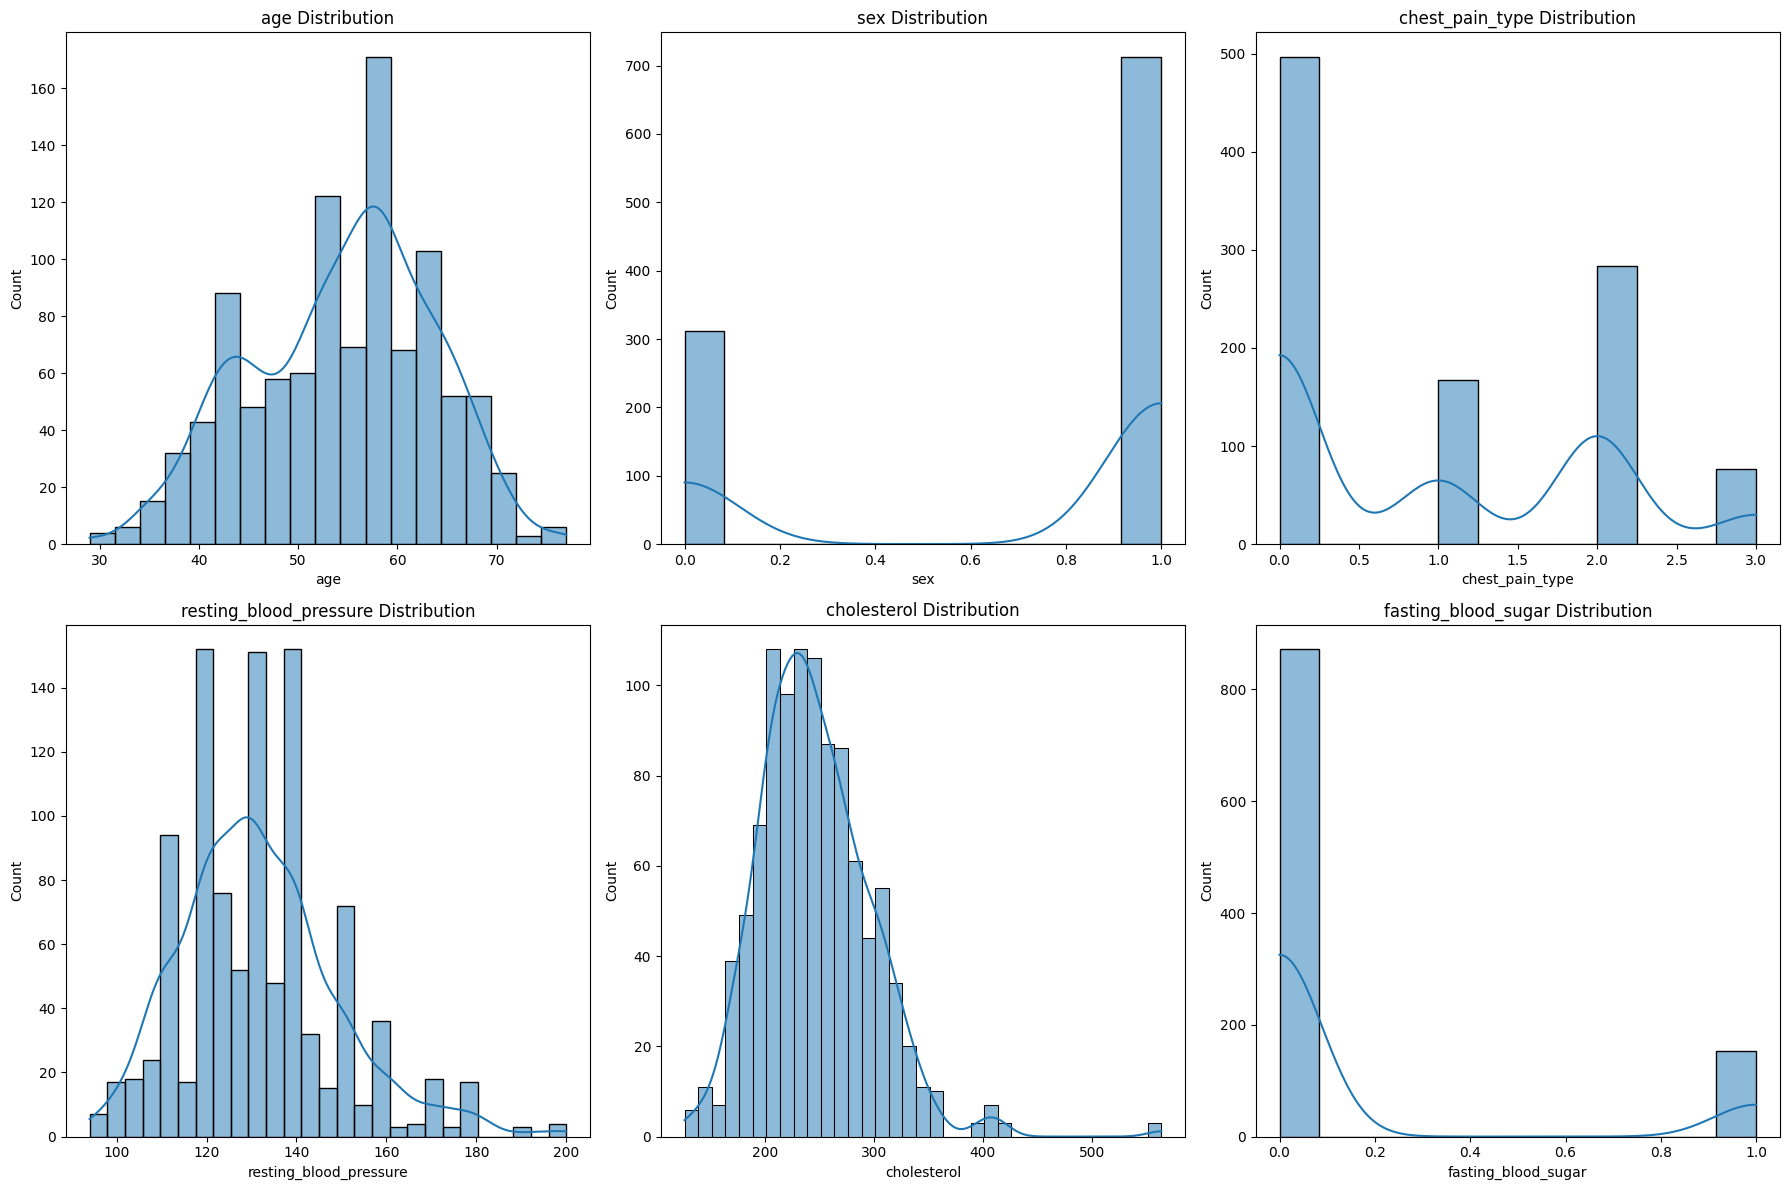

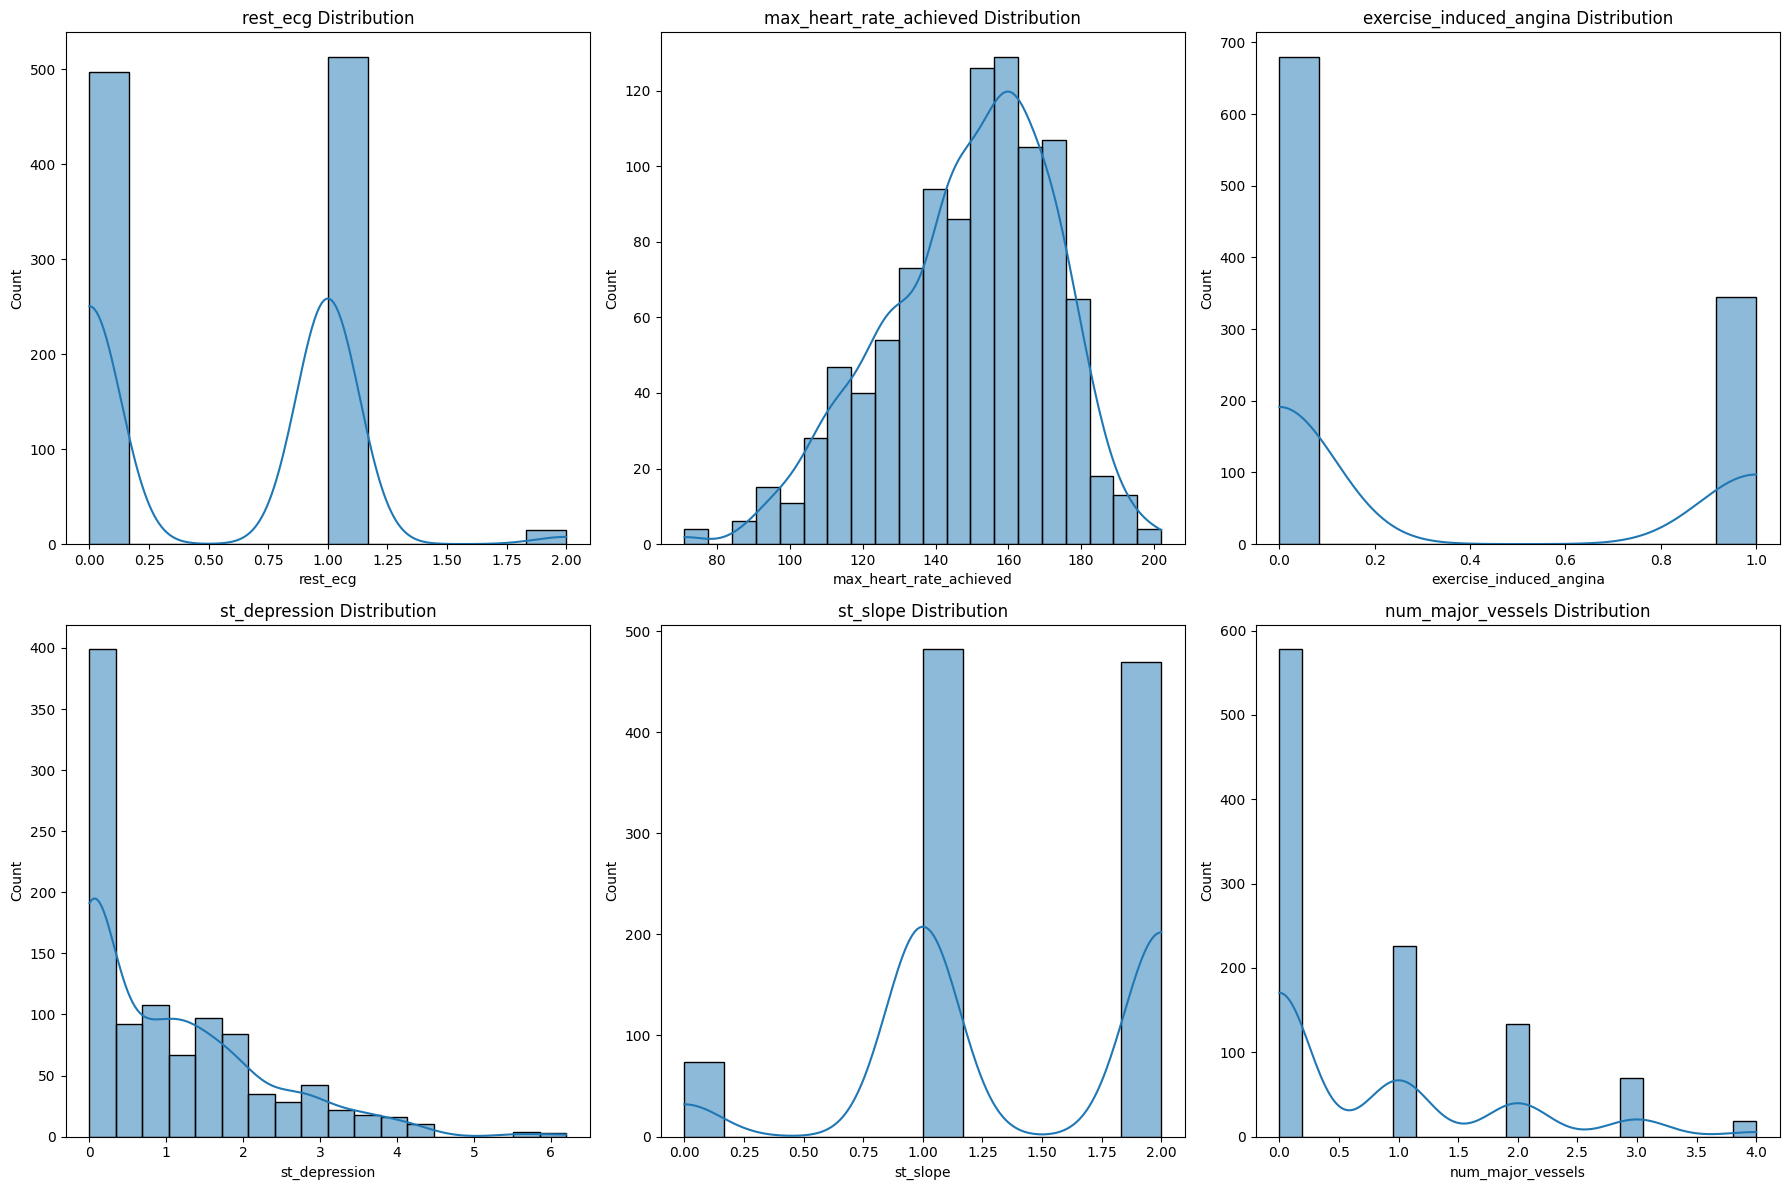

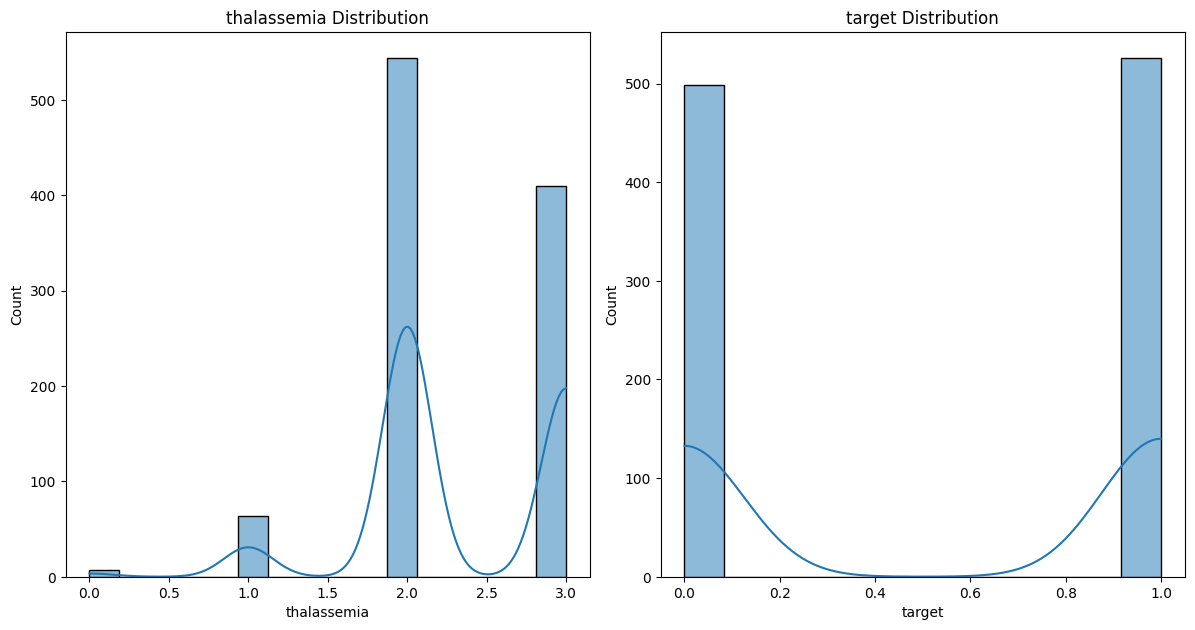

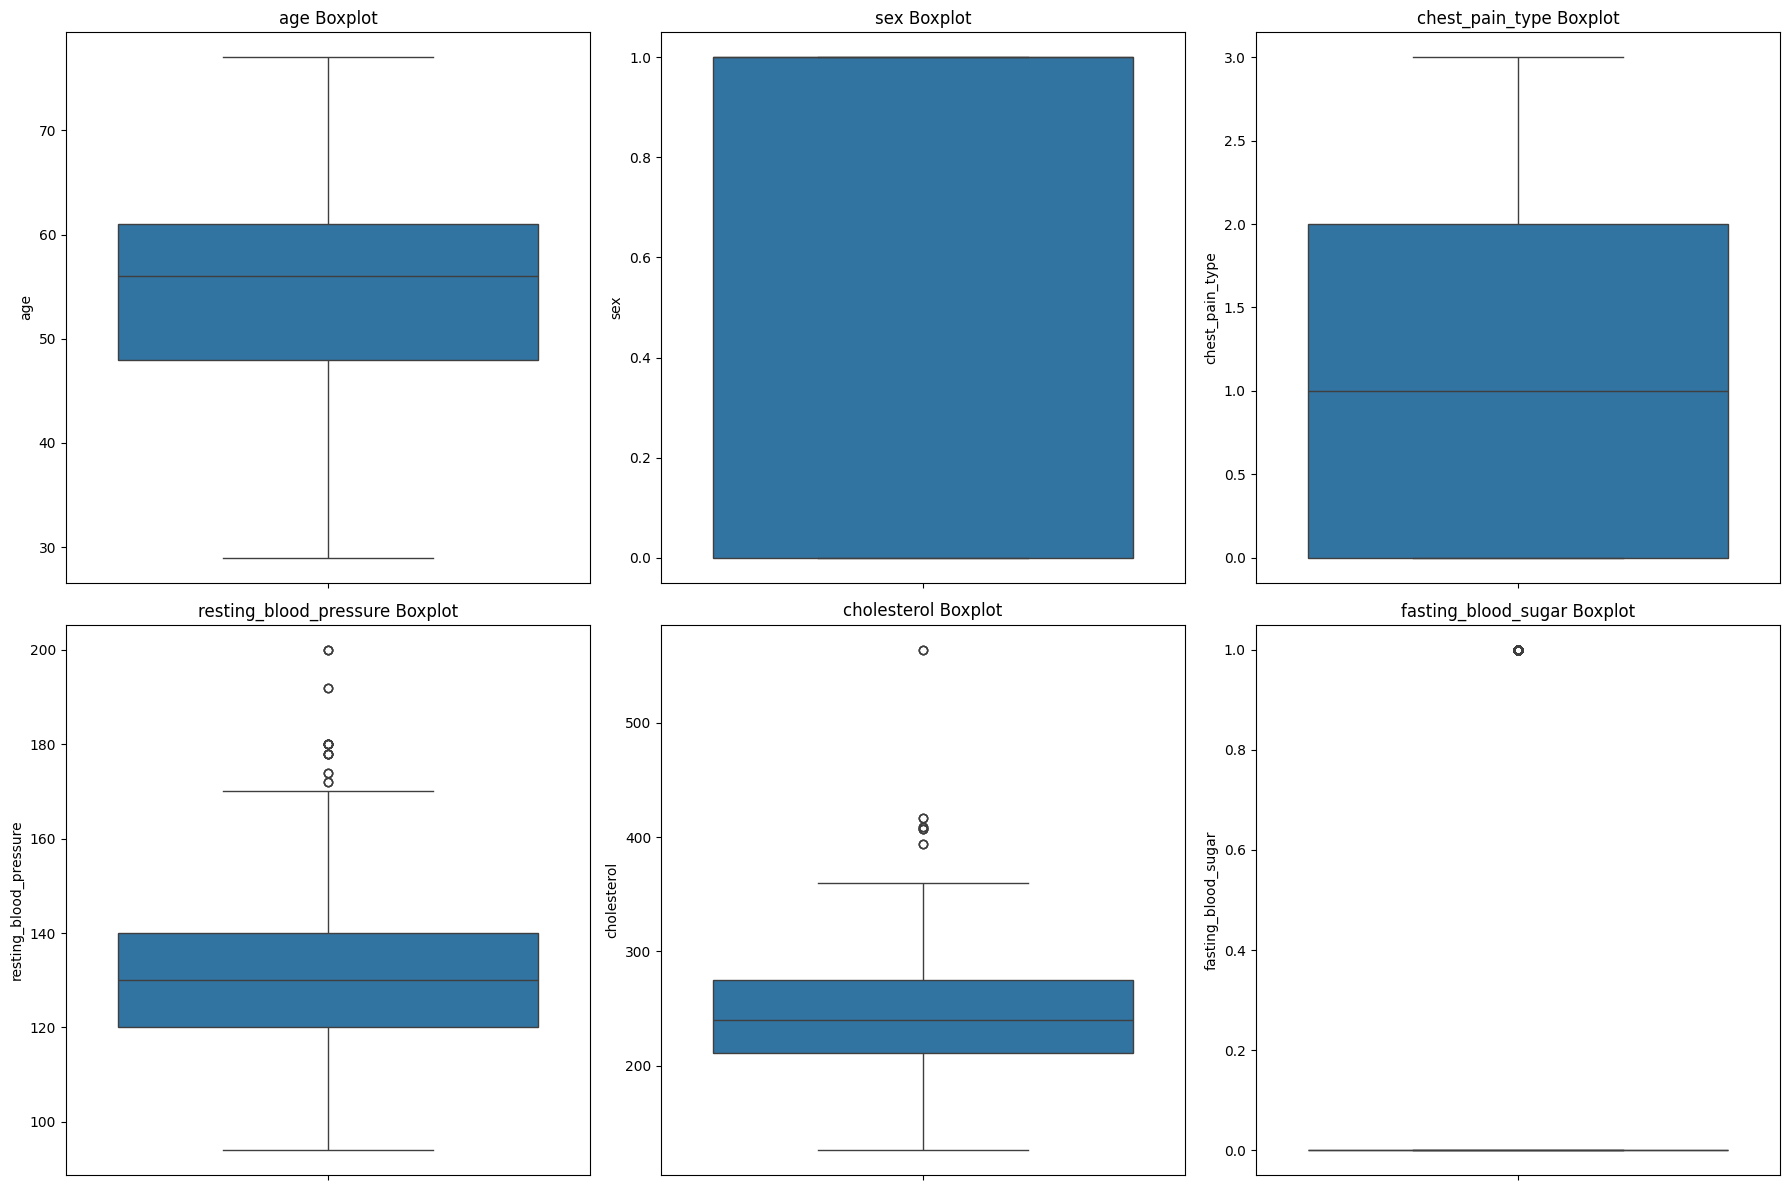

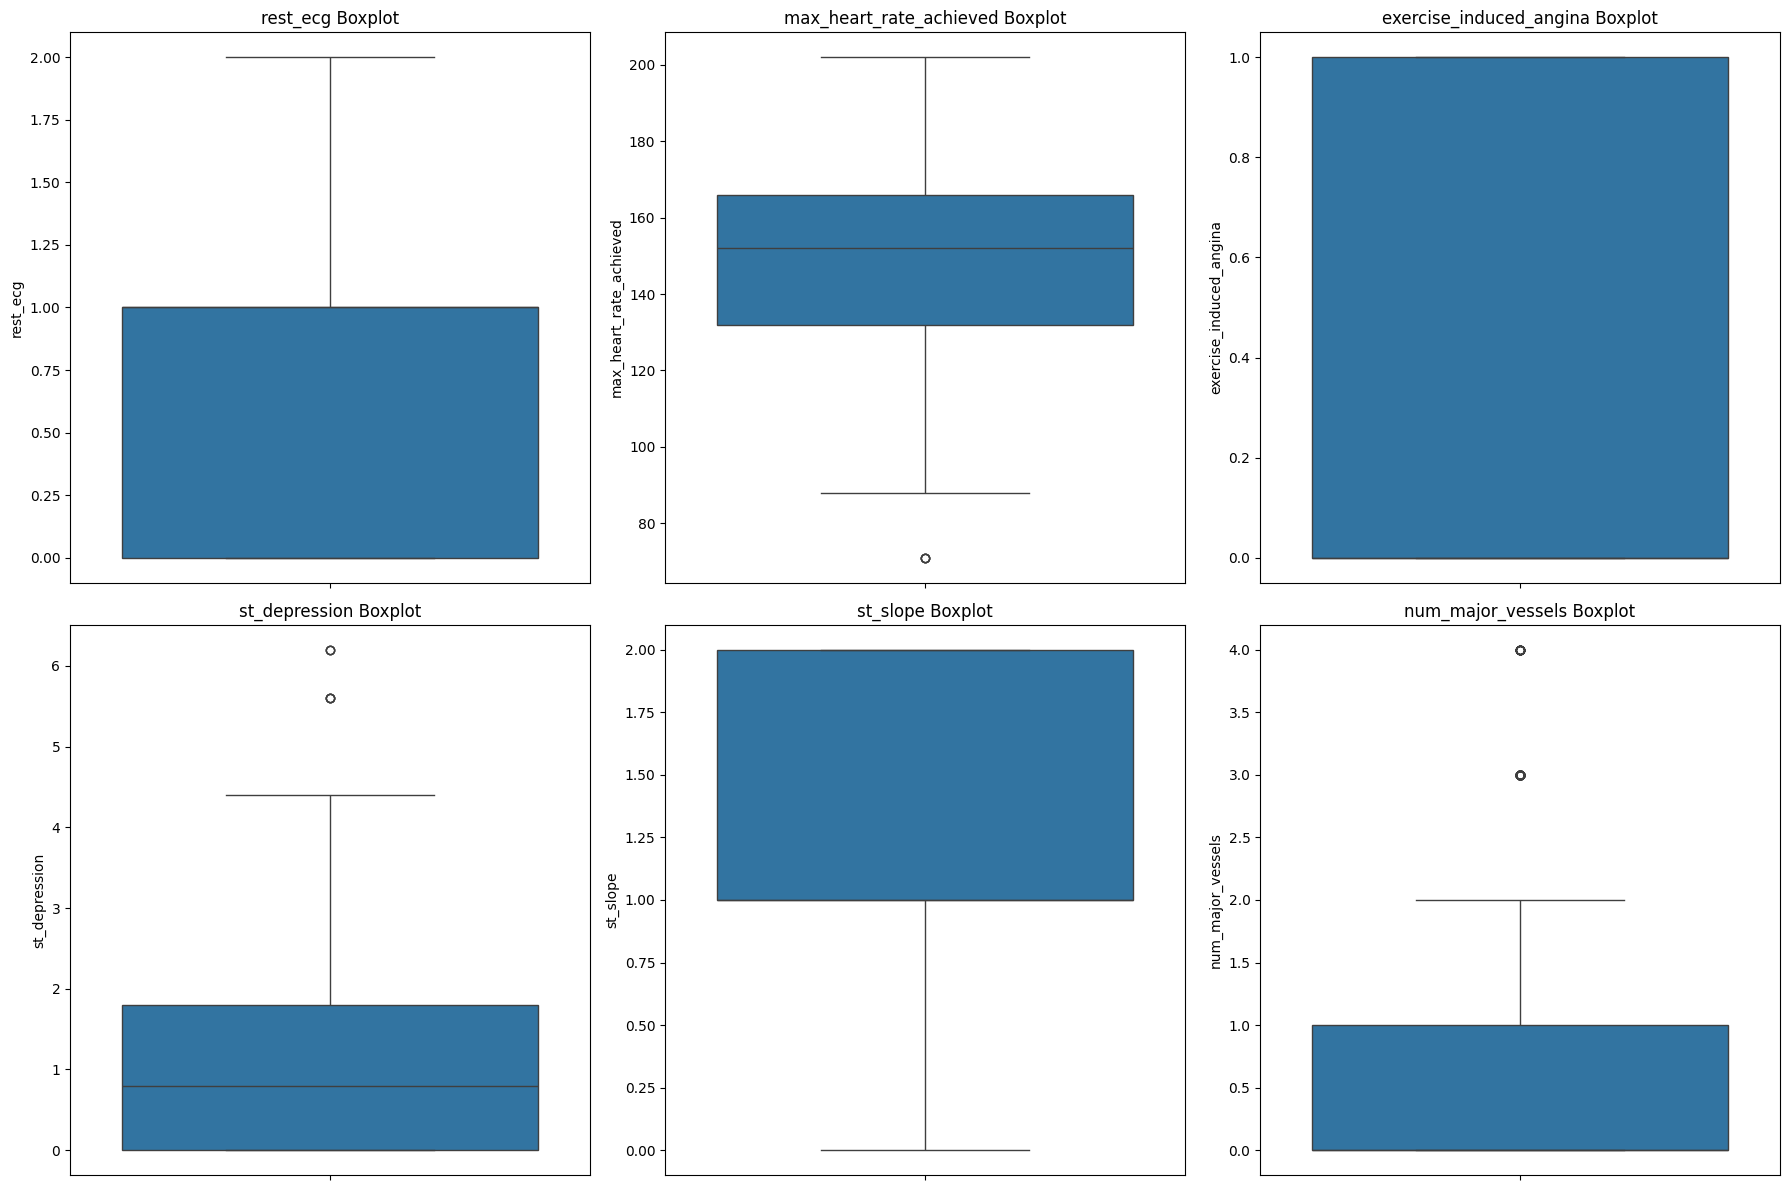

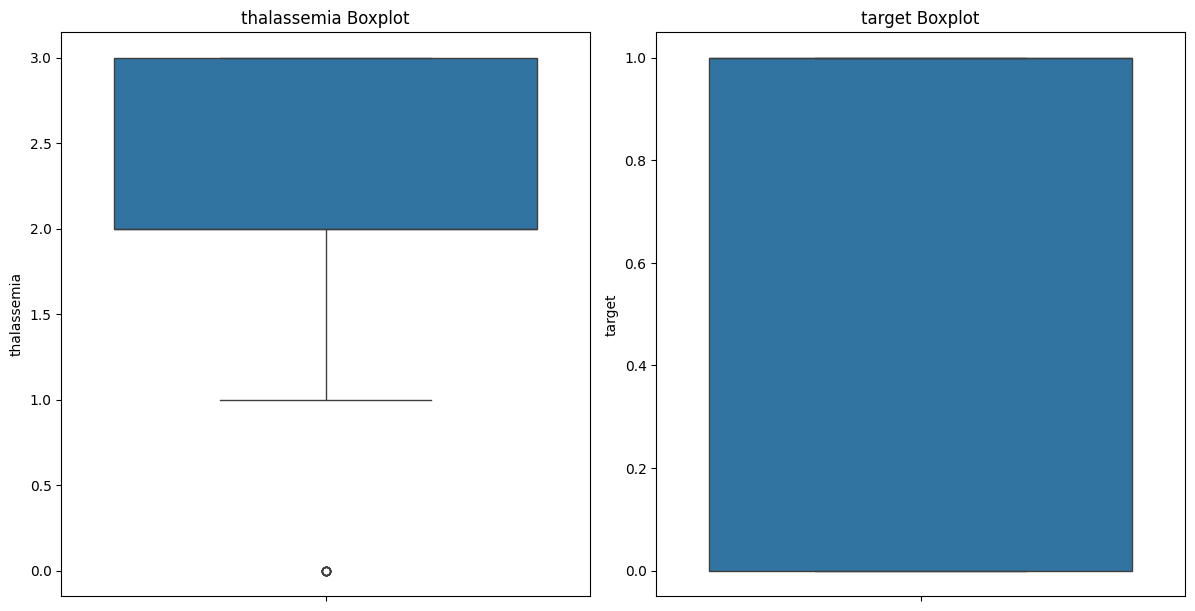

In [12]:
# Visualización de datos
plot_distributions(df)
plot_boxplots(df)

# Parte 3. Preprocesamiento de Datos

In [13]:
# Función para eliminar outliers en variables numéricas
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


## Feature Engineering

In [14]:
# Función para la ingeniería de características
def feature_engineering(df):
    df = df.copy()
    # Crear variables derivadas
    df['cholesterol_bp_ratio'] = df['cholesterol'] / df['resting_blood_pressure']
    df['age_sex_interaction'] = df['age'] * df['sex']
    df['age_bins'] = pd.cut(df['age'], bins=[29, 39, 49, 59, 69, 79], labels=['30-39', '40-49', '50-59', '60-69', '70-79'])
    df['cholesterol_category'] = pd.cut(df['cholesterol'], bins=[0, 200, 240, np.inf], labels=['Normal', 'Borderline', 'High'])
    return df

In [15]:
# Función para calcular correlaciones
def calculate_correlations(df, target_column):
    correlations = df.corr(method='pearson')
    target_corr = correlations[target_column]
    return target_corr

In [16]:
# Función para aplicar transformaciones numéricas
def apply_numeric_transformations(df):
    df = remove_outliers(df)
    return df

In [17]:
def apply_feature_engineering(X):
    return feature_engineering(X)

In [18]:
def preprocessor_pipeline():
    # Definir características numéricas y categóricas
    numeric_features = ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate_achieved', 'st_depression']
    categorical_features = ['chest_pain_type', 'rest_ecg', 'st_slope', 'num_major_vessels', 'thalassemia']

    # Crear transformadores para características numéricas
    numeric_transformer = Pipeline(steps=[
        ('remove_outliers', FunctionTransformer(func=apply_numeric_transformations, validate=False)),  # Eliminar outliers
        ('imputer', SimpleImputer(strategy='median')),  # Imputación con mediana
        ('scaler', StandardScaler())  # Estandarización
    ])

    # Crear transformadores para características categóricas
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Imputación con valor constante
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación one-hot
    ])

    # Crear el preprocesador que aplica transformaciones a las características adecuadas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),  # Transformaciones numéricas
            ('cat', categorical_transformer, categorical_features)  # Transformaciones categóricas
        ]
    )
    return preprocessor

# Exportación de Dataframe Preprocesado

In [19]:
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [20]:
def create_and_save_pipeline():
    preprocessor = preprocessor_pipeline()
    
    # Crear un pipeline completo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_engineering', FunctionTransformer(func=apply_feature_engineering, validate=False))
    ])
    
    # Guardar el pipeline en un archivo .pkl
    file_path = '../files/data_pipeline.pkl'
    ensure_dir(file_path)
    joblib.dump(pipeline, file_path)


In [21]:
# Ejecutar la función para guardar el pipeline
create_and_save_pipeline()